In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

In [2]:
figure_size=(15,6)

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [4]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

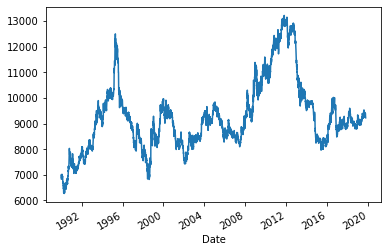

In [5]:
# Plot just the "Settle" column from the dataframe:
# YOUR CODE HERE!
yen_futures.Settle.plot()


---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [6]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
# YOUR CODE HERE!

settle_noise, settle_trend = sm.tsa.filters.hpfilter(yen_futures["Settle"])


In [7]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!
data = pd.concat([yen_futures.Settle, settle_noise, settle_trend], axis="columns", join="inner")
data

,Settle,Settle_cycle,Settle_trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062
...,...,...,...
2019-10-09,9338.0,24.939247,9313.060753
2019-10-10,9303.5,-5.868559,9309.368559
2019-10-11,9251.0,-54.454594,9305.454594


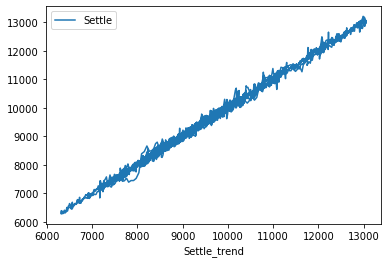

In [8]:
# Plot the Settle Price vs. the Trend for 2015 to the present
# YOUR CODE HERE!
data.plot( x = "Settle_trend", y ="Settle")

In [9]:
dataframe = pd.concat([yen_futures.Settle, settle_noise, settle_trend], axis="columns", join="inner")
dataframe

,Settle,Settle_cycle,Settle_trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062
...,...,...,...
2019-10-09,9338.0,24.939247,9313.060753
2019-10-10,9303.5,-5.868559,9309.368559
2019-10-11,9251.0,-54.454594,9305.454594


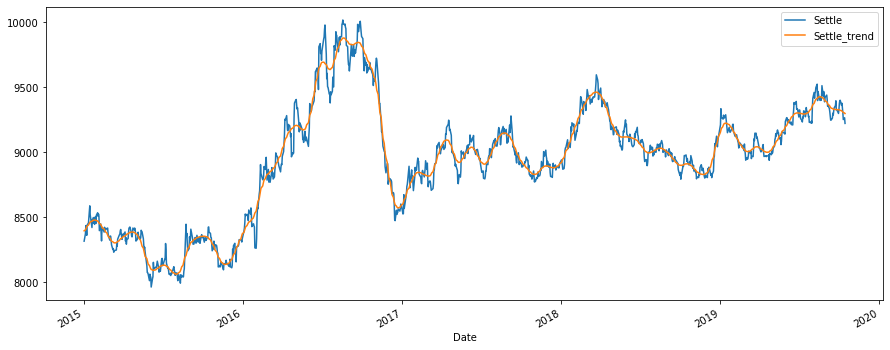

In [10]:
# Plot the Settle Price vs. the Trend for 2015 to the present
dataframe=dataframe.loc["2015-01-01":,:]
dataframe.drop(columns=["Settle_cycle"]).plot(figsize=figure_size)
#dataframe.reindex(["Settle", "Trend"]).plot()

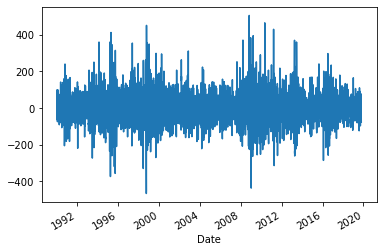

In [11]:
# Plot the Settle Noise
# YOUR CODE HERE!
settle_noise.plot()

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [12]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [13]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!
model = ARIMA(returns.values, order=(5, 1, 1))

# Fit the model and assign it to a variable called results
# YOUR CODE HERE!
result = model.fit()

In [14]:
# Output model summary results:
# YOUR CODE HERE!
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7513
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -7895.588
Method:                       css-mle   S.D. of innovations              0.692
Date:                Sun, 13 Dec 2020   AIC                          15807.177
Time:                        23:13:39   BIC                          15862.572
Sample:                             1   HQIC                         15826.198
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.203e-06   3.54e-06     -0.905      0.366   -1.01e-05    3.74e-06
ar.L1.D.y     -0.0118      0.012     -1.025      0.305      -0.034       0.011
ar.L2.D.y     -0.0004      0.012     -0.034      0.973      -0.023       0.022
ar.L3.D.y     -0.0132      0.012     -1.142      0.253      -0.036       0.009
ar.L4.D.y     -0.0194      0.012     -1.677      0.094      -0.042       0.003
ar.L5.D.y     -0.0021      0.012     -0.185      0.853      -0.025       0.020
ma.L1.D.y     -0.9999      0.000  -2515.973      0.000      -1.001      -0.999
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7464           -1.7666j            2.4841           -0.1259
AR.2            1.7464           +1.7666j            2.4841            0.1259
AR.3           -2.0698           -2.1751j            3.0026           -0.3711
AR.4           -2.0698           +2.1751j            3.0026            0.3711
AR.5           -8.4268           -0.0000j            8.4268           -0.5000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

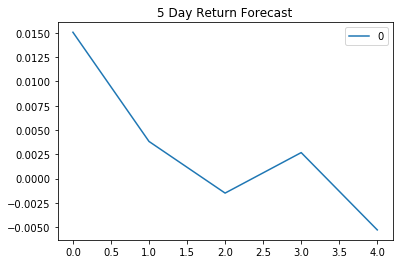

In [15]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!
pd.DataFrame(result.forecast(steps=5)[0]).plot(title="5 Day Return Forecast")


---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [16]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!
#model = ARIMA(result.settle.value, order=(5, 1, 1))
model = ARIMA(dataframe.Settle.values,order=(5, 1, 1))
# Fit the model
# YOUR CODE HERE!
results = model.fit()

In [17]:
# Output model summary results:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7513
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -7895.588
Method:                       css-mle   S.D. of innovations              0.692
Date:                Sun, 13 Dec 2020   AIC                          15807.177
Time:                        23:13:42   BIC                          15862.572
Sample:                             1   HQIC                         15826.198
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.203e-06   3.54e-06     -0.905      0.366   -1.01e-05    3.74e-06
ar.L1.D.y     -0.0118      0.012     -1.025      0.305      -0.034       0.011
ar.L2.D.y     -0.0004      0.012     -0.034      0.973      -0.023       0.022
ar.L3.D.y     -0.0132      0.012     -1.142      0.253      -0.036       0.009
ar.L4.D.y     -0.0194      0.012     -1.677      0.094      -0.042       0.003
ar.L5.D.y     -0.0021      0.012     -0.185      0.853      -0.025       0.020
ma.L1.D.y     -0.9999      0.000  -2515.973      0.000      -1.001      -0.999
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7464           -1.7666j            2.4841           -0.1259
AR.2            1.7464           +1.7666j            2.4841            0.1259
AR.3           -2.0698           -2.1751j            3.0026           -0.3711
AR.4           -2.0698           +2.1751j            3.0026            0.3711
AR.5           -8.4268           -0.0000j            8.4268           -0.5000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

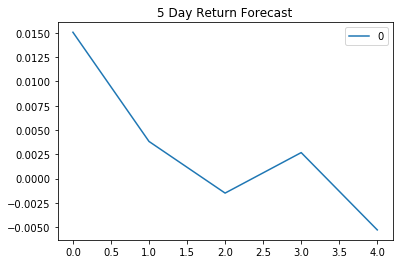

In [18]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!
pd.DataFrame(result.forecast(steps=5)[0]).plot(title="5 Day Return Forecast")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [19]:
from arch import arch_model

In [20]:
# Estimate a GARCH model:
# YOUR CODE HERE!
model= arch_model(returns, mean="Zero", vol= "GARCH", p=2, q=1)
# Fit the model
# YOUR CODE HERE!
results=model.fit(disp="off")

In [21]:
# Summarize the model results
# YOUR CODE HERE!
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Sun, Dec 13 2020   Df Residuals:                     7510
Time:                        23:13:43   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [22]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [23]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
# YOUR CODE HERE!
forecasts=results.forecast(start='2019-10-15', horizon=forecast_horizon)
forecasts

In [24]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [25]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


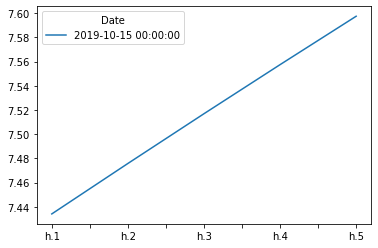

In [26]:
# Plot the final forecast
# YOUR CODE HERE!
#final.plot(title="5 day forecast of volativity")
final.plot()

---

# Conclusions

Based on your time series analysis, would you buy the yen now? Yes, they are volatile enough which means the returns are good

Is the risk of the yen expected to increase or decrease? tee increase and decrease flactuates very quickly for example in the final forcastin 2019, trading in 5 hours showed a high climb but in the predicition including 2020, the price looks stable downwards. There are a number of volatile events that has a big influence on decrease or decreases. Howver in the fast paced techncology platform, the increase albeit little shows progress of an increase.

Based on the model evaluation, would you feel confident in using these models for trading? Yes, although I am not completely conversant with the model, but both esults are not so different from each other, so there is some gigh degree of accuracy.